In [1]:
using Oceananigans
using CairoMakie
using JLD2
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian

[ Info: Oceananigans will use 4 threads


In [23]:
grid = RectilinearGrid(; size=(8, 8, 8), extent=(1, 1, 1), topology=(Open, Open, Bounded))

LoadError: UndefVarError: `Open` not defined

[ Info: Created a front state with Riₘᵢₙ = 10.000048307307447, Roₘᵢₙ = -0.0998964799769908, Roₘₐₓ = 0.10198508704206688


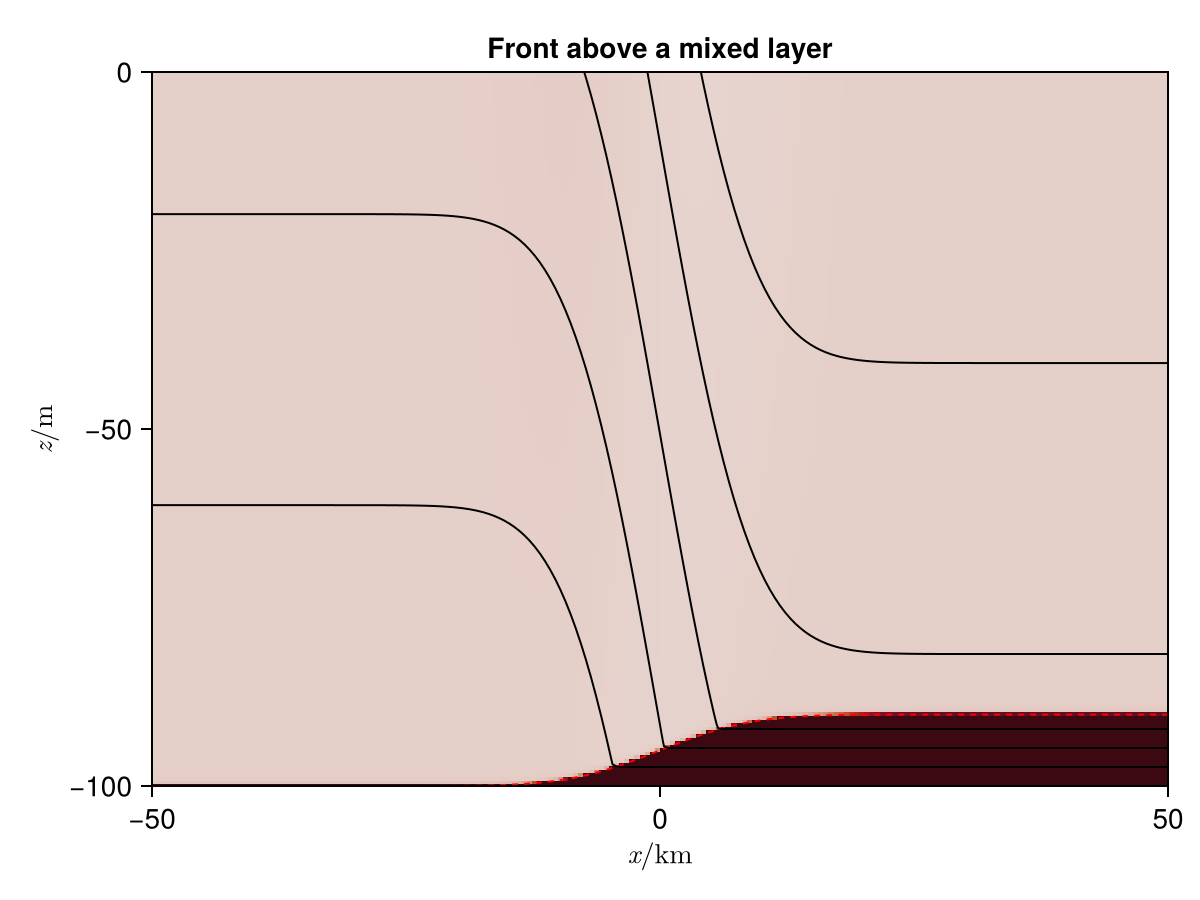

In [20]:
include("../src-fronts/parameters.jl")
include("../src-fronts/base_state.jl")
sp = create_simulation_parameters(; Ri=10, Ro=0.1, Q=100)
b, u, v, w = map(a->(x, z)->a(x, 0, z), get_base_state(sp));

ζ(x, z) = (v(x+5e-8, z) - v(x-5e-8, z)) / 1e-7
N²(x, z) = (b(x, z+5e-8) - b(x, z-5e-8)) / 1e-7
S(x, z) = (v(x, z+5e-8) - v(x, z-5e-8)) / 1e-7
M²(x, z) = (b(x+5e-8, z) - b(x-5e-8, z)) / 1e-7

q(x, z) = (ζ(x, z) + sp.f) * N²(x, z) - S(x, z) * M²(x, z)

xs = range(-sp.Lx/2000, sp.Lx/2000, 200)
zs = range(-sp.H, 0, 200)

Ri = [N²(x, z) / S(x, z)^2 for x in xs, z in zs]
Ro = [ζ(x * 1000, z) / sp.f for x in xs, z in zs]

Riₘᵢₙ = minimum(Ri)
Roₘᵢₙ = minimum(Ro)
Roₘₐₓ = maximum(Ro)

@info "Created a front state with Riₘᵢₙ = $Riₘᵢₙ, Roₘᵢₙ = $Roₘᵢₙ, Roₘₐₓ = $Roₘₐₓ"

fig = Figure()
ax = Axis(fig[1, 1]; xlabel=L"x / \text{km}", ylabel=L"z / \text{m}", title="Front above a mixed layer", limits=(-sp.Lx/2000, sp.Lx/2000, -sp.H, 0))
h(x, z) = z - sp.H * γ(x/sp.ℓ, 0.1)

#contourf!(ax, xs, zs, (x, z)->v(1000x, z); levels=range(-2v(0, 0), 2v(0, 0), 20), colormap=:balance)
heatmap!(ax, xs, zs, (x, z)->q(1000x, z); colormap=:balance, colorrange=(-10sp.f * sp.N², 10sp.f * sp.N²))
contour!(ax, xs, zs, (x, z)->q(1000x, z); levels=[0], color=:blue)
contour!(ax, xs, zs, (x, z)->h(1000x, z); color=:red, levels=[0], linestyle=:dash)
contour!(ax, xs, zs, (x, z)->b(1000x, z); color=:black)
fig

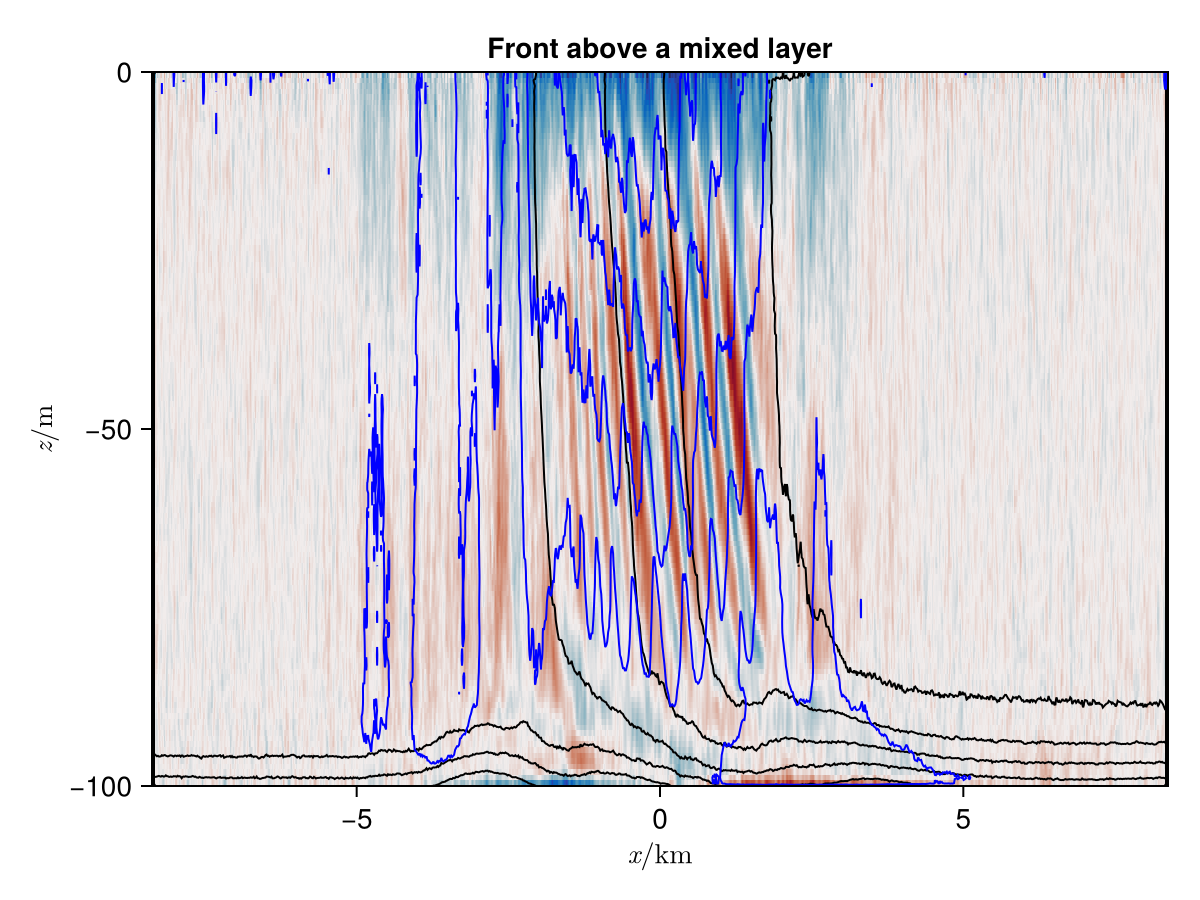

In [22]:
# Print simulation outputs
# Get a state of simulation
n = 1001
foldername = "../../scratch/Project/front-init-test"

sp = jldopen("$foldername/parameters.jld2") do file
    NamedTuple(map(keys(file)) do k
        Pair(Symbol(k), file[k])
            end)
end
filename = "$foldername/initialisation.jld2"
t, xs, ys, zs, u, v, w, b, φ = jldopen(filename) do file
    frames = keys(file["timeseries/t"])
    ts = [file["timeseries/t/$frame"] for frame in frames]
    frame = frames[n]
    xs = file["grid/xᶜᵃᵃ"]
    ys = file["grid/yᵃᶜᵃ"]
    zs = file["grid/zᵃᵃᶜ"]
    u = (file["timeseries/u/$frame"][1:end-1, :, :] .+ file["timeseries/u/$frame"][2:end, :, :]) ./ 2
    v = (circshift(file["timeseries/v/$frame"], (0, -1, 0)) .+ circshift(file["timeseries/v/$frame"], (0, 1, 0))) ./ 2
    w = (file["timeseries/w/$frame"][:, :, 1:end-1] .+ file["timeseries/w/$frame"][:, :, 2:end]) ./ 2
    b = file["timeseries/b/$frame"]
    φ = file["timeseries/φ/$frame"]
    ts[n], xs, ys, zs, u, v, w, b, φ
    end;
fig = Figure()
ax = Axis(fig[1, 1]; xlabel=L"x / \text{km}", ylabel=L"z / \text{m}", title="Front above a mixed layer", limits=(xs[1]/1000, xs[end]/1000, -sp.H, 0))
#field = mean((v .- mean(v; dims=2)) .* (w .- mean(w; dims=2)); dims=2)[:, 1, :]
#ψ = mean(cumsum(u; dims=3) * (zs[2]-zs[1]); dims=2)[:, 1, :]
b_levels = range(minimum(mean(b; dims=2)), maximum(mean(b; dims=2)), 40)
#field = field - imfilter(field, gaussian((10, 0)))
field = mean(u; dims=2)[:, 1, :]
#field = imfilter(field, gaussian((30, 0)))
#field = circshift(mean(φ; dims=2)[:, 1, :], (-1, 0)) .- circshift(mean(φ; dims=2)[:, 1, :], (1, 0))
heatmap!(ax, xs / 1000, zs, field; colormap=:balance, colorrange=(-maximum(abs, field), maximum(abs, field)))
contour!(ax, xs / 1000, zs, mean(b; dims=2)[:, 1, :]; color=:black, levels=b_levels)
contour!(ax, xs / 1000, zs, mean(v; dims=2)[:, 1, :]; color=:blue, levels=5)
#contour!(ax, xs / 1000, zs, ψ; colormap=:balance, colorrange=(-maximum(abs, ψ), maximum(abs, ψ)), levels=3)

fig

In [10]:
v = mean(v; dims=2)[:, 1, :]
shear = ((v[:, 1:end-2] - v[:, 3:end]) / (zs[3]-zs[1]))
shear = imfilter(shear, gaussian((3, 1)))[4:end-3, 3:end-2]
field = imfilter(field, gaussian((3, 1)))[4:end-3, 4:end-3];

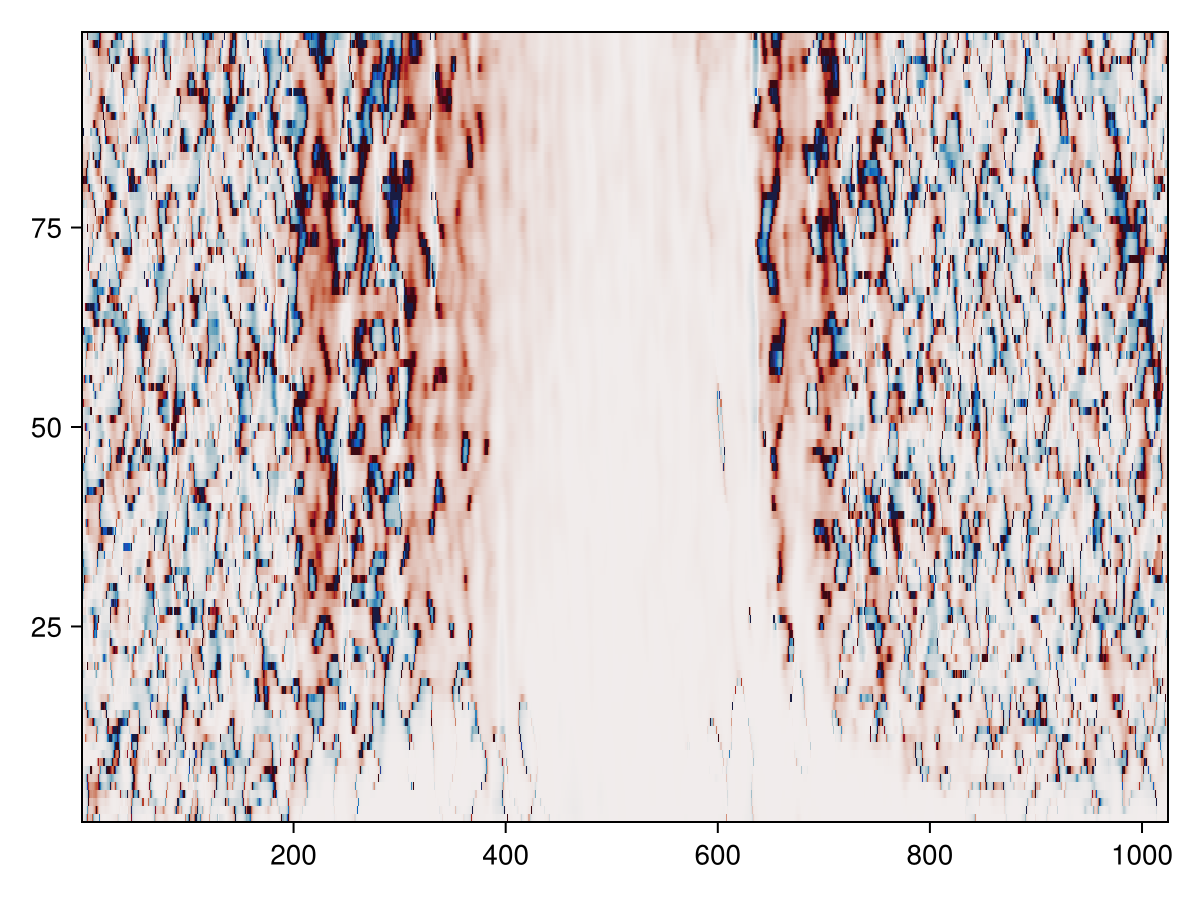

In [13]:
heatmap(field[:, 10:end-20] ./ shear[:, 10:end-20]; colormap=:balance, colorrange=(-0.1, 0.1))

In [ ]:
ts, xs, zs, u_long, v_long, w_long, b_long = jldopen(filename) do file
    frames = keys(file["timeseries/t"])
    ts = [file["timeseries/t/$frame"] for frame in frames]
    frame = frames[n]
    xs = file["grid/xᶜᵃᵃ"][4:end-3]
    zs = file["grid/zᵃᵃᶜ"][4:end-3]
    
    u = [mean(file["timeseries/u/$frame"][:, :, end-20]; dims=2)[4:end-3, 1] for frame in frames]
    u = [u[j][i] for i in 1:length(xs), j in 1:length(frames)]
    v = [mean(file["timeseries/v/$frame"][:, :, end-20]; dims=2)[4:end-3, 1] for frame in frames]
    v = [v[j][i] for i in 1:length(xs), j in 1:length(frames)]
    w = [mean(file["timeseries/w/$frame"][:, :, end-20]; dims=2)[4:end-3, 1] for frame in frames]
    w = [w[j][i] for i in 1:length(xs), j in 1:length(frausines)]
    b = [mean(file["timeseries/b/$frame"][:, :, end-20]; dims=2)[4:end-3, 1] for frame in frames]
    b = [b[j][i] for i in 1:length(xs), j in 1:length(frames)]
    ts, xs, zs, u, v, w, b
    end;

LoadError: InterruptException:

In [19]:
fig = Figure(; size=(1100, 500))
ax = Axis(fig[1, 1]; title = "Across-front velocity after cooling switched on, Ri=0, Q=10Wm⁻²", xlabel="x / km", ylabel="ft / 2π", limits=(nothing, (0, nothing)))
field = u_long[:, :, end]
heatmap!(ax, xs / 1000, ts * sp.f / (2π), field; colormap=:balance, colorrange=(-maximum(abs, field), maximum(abs, field)))
contour!(ax, xs / 1000, ts * sp.f / (2π), b_long[4:end-3, :, end-5]; color=:black, levels=50)

ax = Axis(fig[1, 2]; title = "Vertical velocity after cooling switched on, Ri=0, Q=10Wm⁻², coarse-grained", xlabel="x / km", ylabel="ft / 2π", limits=(nothing, (0, nothing)))
field = imfilter(w[:, :, end], gaussian((10, 0)), "circular")
heatmap!(ax, xs / 1000, ts * sp.f / (2π), field; colormap=:balance, colorrange=(-maximum(abs, field), maximum(abs, field)))
contour!(ax, xs / 1000, ts * sp.f / (2π), b[4:end-3, :, end-5]; color=:black, levels=50)
fig

LoadError: UndefVarError: `ts` not defined